<a href="https://colab.research.google.com/github/AVJdataminer/COVID19_GC/blob/master/COVID19_GuidedCapstoneStep4andStep5_AnswerKey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Guided Capstone Step 4. Pre-processing and Training Data Development - Answer Key

In the previous step we used Lasso Regression to attempt to model the number of confirmed cases across all reporting countries. It was clear from those results that we needed a more specific approach so we have subset our data to include only the United States for this next step. 
We are also going to combine steps 4 and 5 of the DSM in this notebook.

**The Data Science Method**  


1.   Problem Identification 


2.   Data Wrangling 
  
 
3.   Exploratory Data Analysis   

4.   **Pre-processing and Training Data Development**  
 * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
5.   **Modeling** 
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

**<font color='DarkBlue'> Start by loading the necessary packages as we did in step 3 and printing out our current working directory just to confirm we are in the correct project directory. </font>**

In [16]:
import os
import pandas as pd
import datetime
import seaborn as sns
from matplotlib import pyplot as plt
import json
%matplotlib inline
import plotly.graph_objects as go 
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,explained_variance_score,mean_absolute_error
from math import sqrt
from sklearn.metrics import explained_variance_score
os.listdir()

['COVID19_GuidedCapstoneStep4andStep5_AnswerKey_downloaded.ipynb',
 '.ipynb_checkpoints',
 'COVID19_GuidedCapstoneSteps_1_and_2_noapi_answerkey.ipynb',
 'COVID19_GuidedCapstoneStep4andStep5_AnswerKey.ipynb',
 'COVID19_GuidedCapstoneStep3_AnswerKey.ipynb']

**<font color='DarkBlue'> If you need to change your path refer back to the notebook on steps 1 & 2 on how to do that. Then load the csv file you created in step 3, remember it should be saved inside your data subfolder and print the first five rows.</font>**

In [2]:
file='https://raw.githubusercontent.com/AVJdataminer/COVID19_GC/master/%20data/step3_output.csv'
df=pd.read_csv(file)
df.head()

,confirmed,deaths,timestamp,province_state,long,country_region,timestamp.date,lat,recovered,date,...,deaths_26_day_pct_change,confirmed_27_day_pct_change,recovered_27_day_pct_change,deaths_27_day_pct_change,confirmed_28_day_pct_change,recovered_28_day_pct_change,deaths_28_day_pct_change,confirmed_29_day_pct_change,recovered_29_day_pct_change,deaths_29_day_pct_change
0,839675.0,46583.0,1587556800,missing,-95.7129,US,2020-04-22,37902.0,77366.0,2020-04-22,...,28.464263,9.015685,NaN,37.530190,11.765286,NaN,48.451168,18.150113,NaN,82.631957
1,823786.0,44845.0,1587470400,missing,-95.7129,US,2020-04-21,37902.0,75204.0,2020-04-21,...,36.092639,11.523731,NaN,46.606157,17.787739,NaN,79.511670,23.756161,NaN,106.541966
2,784326.0,42094.0,1587384000,missing,-95.7129,US,2020-04-20,37902.0,72329.0,2020-04-20,...,43.685775,16.887792,NaN,74.572711,22.570321,NaN,99.944844,29.771156,NaN,136.114007
3,759086.0,40661.0,1587297600,missing,-95.7129,US,2020-04-19,37902.0,70337.0,2020-04-19,...,72.000000,21.811816,NaN,96.508393,28.780925,NaN,131.446254,38.742723,NaN,165.643443
4,732197.0,38664.0,1587211200,missing,-95.7129,US,2020-04-18,37902.0,64840.0,2020-04-18,...,91.719424,27.725999,NaN,124.941368,37.334921,NaN,157.459016,52.534913,NaN,192.320000


Let's create the same plot we created in step 3 for only the US data over the same timeframe.

In [6]:
#create summarized counts for plot
ds = df.groupby(['timestamp.date']).agg({'confirmed':'sum','deaths':'sum', 'recovered':'sum'}).reset_index()

In [7]:
#create plot
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=ds['timestamp.date'],
                y=ds['confirmed'],
                name="confirmed",
                line_color='red',
                opacity=0.8))
fig.add_trace(go.Scatter(
                x=ds['timestamp.date'],
                y=ds['deaths'],
                name="deaths",
                line_color='dimgray',
                opacity=0.8))
fig.add_trace(go.Scatter(
                x=ds['timestamp.date'],
                y=ds['recovered'],
                name="recovered",
                line_color='green',
                opacity=0.8))

# Use date string to set xaxis range
fig.update_layout(xaxis_range=['2020-01-22','2020-04-22'],
                  title_text="COVID-19 US Confirmed Cases")
fig.show()

Notice that much the early data points have very few observations. This is an important consideration in our modeling approach and indicates the potential benefit from subsetting to a later start date in our modeling process when applied to the US data only. Also, remember we created those percent changes by number of days features in the last notebook which will also be zero or nan for the earlier time period in the data. We will come back to this point later on in the notebook. For now let's subset the data to March 15, 2020 based on the plot.

Subset the data to March 15 and later.

In [44]:
#set the date col datatype to date
df['date'] = pd.to_datetime(df['date'],format = "%Y-%m-%d")
#use pd.timestamp to filter based on specified date
df = df[(df['date']>pd.Timestamp(2020,3,15))]
#review the new shape of the data. frame
df.shape

(37, 100)

## Create dummy features for categorical variables - when applicable.

**<font color='DarkBlue'> Check the values for `province_state` and determine if dummies need to be created, if so, add the dummies back to the dataframe and remove the original column for `province_state`. </font>**

In [45]:
df.province_state.value_counts()

missing    37
Name: province_state, dtype: int64

**<font color='DarkBlue'> Currently there are no states in this dataset so we skip this step. </font>** But the code is provided here for your reference.

In [46]:
#df = pd.concat([df, pd.get_dummies(df['province_state'])], axis=1).drop(['province_state'], axis =1)
#print(df.shape)
#df.head()

## Standardize the magnitude of numeric features

In the last step you may remember we applied a scaler to our data before fitting the Lasso Regression, however, we didn't save that in the output data so we will need to apply that step again before modeling the US data. Additionally, we need use the simple imputer to fill the nan or null values once again. Start by filling the null values than apply the scaler to the filled numpy array. 

**<font color='DarkBlue'> Let's start by selecting the confirmed cases as our response variable, define that in the next cell and create a y array from the response values. </font>**

In [47]:
response ='confirmed'
y = df[[response]].values

**<font color='DarkBlue'> Next, apply the simple imputer and the mean strategy to fill the missing or null values in our data frame. </font>** Exclude the response variable from this function.

In [48]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = df.drop([response], axis=1)._get_numeric_data()
imputer=imp.fit(X)
X_filled=imputer.transform(X)

**<font color='DarkBlue'> Apply the standard scaler from sklearn preprocessing. </font>**

In [49]:
scaler = preprocessing.StandardScaler().fit(X_filled)
X_scaled=scaler.transform(X_filled)

Now we are ready to split the data into trianing and testing subsets. In this project our data spans a timeframe and therefore can be considered a timeseries. The benefit from building a model to predict the number of confirmed COVID19 cases is in the ability to forecast the future number. We care less about the ability to properly estimate the current amount of COVID cases and are mor concerned with ability to forecast the potential future number of cases.  

Therefore, when it comes to splitting the data we want to train our model on data from the first part of the time series and test it on the most recent portion to confirm the model is capable of forecasting.

## Split into training and testing datasets

**<font color='DarkBlue'> Split the data into training and testing data subset based on date.</font>** Use the function provided to split the data by 80/20 for traing and testing, while keeping the dates in mind.

In [50]:
from datetime import datetime,timedelta
def dt_splitter(date_col, X, y, test_size):
        date_col = pd.to_datetime(date_col)
        xw_date=pd.DataFrame(X).merge(date_col,left_index=True, right_index=True)
        ad = (max(xw_date.date)- min(xw_date.date)).days*test_size
        split_date = min(xw_date.date) + timedelta(days=ad)
        X_train = xw_date.loc[xw_date['date'] <= split_date].drop(['date'], axis=1).values
        X_test = xw_date.loc[xw_date['date'] > split_date].drop(['date'], axis=1).values
        yw_date=pd.DataFrame(y).merge(date_col,left_index=True, right_index=True)
        y_train=yw_date.loc[yw_date['date'] <= split_date].drop(['date'], axis=1).values
        y_test=yw_date.loc[yw_date['date'] > split_date].drop(['date'], axis=1).values
        return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test=dt_splitter(df['date'], X_scaled, y, .80)

# Modeling
## Fit a Lasso Regression model

Lasso regression is a type of linear regression that uses a penalty to push non-informative features coefficients to zero. It automates the feature selection process in this way. [Learn more about Lasso Regression in a short course created by Breakthrough Data Science.](https://docs.google.com/document/d/e/2PACX-1vTgO2Fykp7R1xB5VSxgCQ0R_iOi_nNEBHqGsN0VOiiGCkXNkfGqXHDpZCT0kW3wsZSJbVr0fvtuCFIz/pub)  

**<font color='DarkBlue'> Fit the Lasso Regression model as we did in the step three notebook. </font>**

In [70]:
lassoreg = Lasso(alpha=0.001,normalize=True, max_iter=1e5)
lassoreg.fit(X_train,y_train)
y_pred = lassoreg.predict(X_test)
print('Mean explained variance score for confirmed cases for the testing period = %.2f.' % explained_variance_score(y_test, y_pred))

Mean explained variance score for confirmed cases for the testing period = 0.34.


In [71]:
print('Mean absolute error for confirmed cases for the testing period = %.0f cases.' % mean_absolute_error(y_test, y_pred))

Mean absolute error for confirmed cases for the testing period = 144687 cases.


In [91]:
# Calculate mean absolute percentage error (MAPE)
y_true, y_pred = np.array(y_test), np.array(y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Lasso Regression Model Accuracy:', round(accuracy, 2), '%.')

Lasso Regression Model Accuracy: 79.33 %.


Plot the lasso forecast with the test samples.

Text(0,0.5,'Actual')

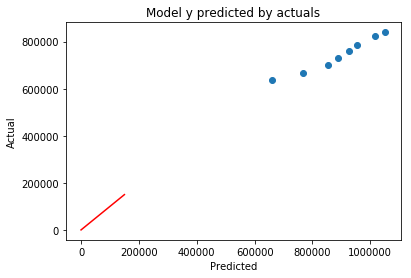

In [53]:
plt.scatter(y_pred,y_test)
plt.plot([x for x in range(0,150000)],[x for x in range(0,150000)], color='red')
plt.title("Model y predicted by actuals")
plt.xlabel("Predicted")
plt.ylabel("Actual")

Results aren't great let's try another modeling method, such as Random Forest Regression.

## Fit a Random Forest Regression model

In [87]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 500, random_state = 42)

rf.fit(X_train,y_train.ravel());

In [88]:
# Use the random forest's predict method on the test data
predictions = rf.predict(X_test)
print('Mean Absolute Error: %.0f cases.' % mean_absolute_error(y_test, predictions))

Mean Absolute Error: 158537 cases.


In [92]:
# Calculate mean absolute percentage error (MAPE)
y_true, y_pred = np.array(y_test), np.array(predictions)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('RF Accuracy:', round(accuracy, 2), '%.')

RF Accuracy: 79.33 %.


Now let's try an additional modeling method and see if we can improve our results. Given the topic at hand is a time series let's delve into ARIMA models and build one on our COVID19 data.

## What is a timeseries?
Time is a different variable all together. It has unique characteristics on to itself. We can discuss these characteristics as the three topics of trends, seasonality, and events.

Trends are probably the most common concern with time. Things change over time, and a trend is a way to quantify how that change is occurring. Sometimes that trend will be linear, other times it may have a different functional form. The key is the data is moving in a direction as time passes, and understanding the direction and speed of that change can fundamentally affect a business.

Seasonality is the idea that there is a repeating pattern over some period of time. Ice cream sales are higher in summer than in winter. Retail sales might be stronger on the weekends, or people might tend to miss morning appointments. Seasonality concerns arise whenever you have a repeating pattern over a set, consistent period of time, whether that time period is a season, a week a day, an hour.

Events are a moment in time where everything changes. It can be a phase shift, a shock, or a total change of directions. What it means practically is that what comes before is not the same as what comes after. How that change manifests depends on the data, but the inclusion of time allows us to find events and adjust accordingly.  

As data scientists we need to account for these characteristics of time we have described. 

How do we do this? The most fundamental technique is an extension of least squares regression called ARIMA (or its variations ARMA and ARIMAx) modeling.

## Components of an ARIMA
ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. 
A random variable that is a time series is stationary if its statistical properties are all constant over time.  A stationary series has no trend, its variations around its mean have a constant amplitude, and it wiggles in a consistent fashion, i.e., its short-term random time patterns always look the same in a statistical sense.  The latter condition means that its autocorrelations (correlations with its own prior deviations from the mean) remain constant over time, or equivalently, that its power spectrum remains constant over time.  A random variable of this form can be viewed (as usual) as a combination of signal and noise, and the signal (if one is apparent) could be a pattern of fast or slow mean reversion, or sinusoidal oscillation, or rapid alternation in sign, and it could also have a seasonal component.  An ARIMA model can be viewed as a “filter” that tries to separate the signal from the noise, and the signal is then extrapolated into the future to obtain forecasts. 

## Model Confirmed cases with ARIMA

In [ ]:
#create timeseries data, so only date and confirmed cases data frame.
cdf = df[['date', 'confirmed']]
cdf['date'] = pd.to_datetime(cdf['date'])
cdf.set_index('date', inplace = True)

In [ ]:
y = cdf['confirmed']
y.plot()

In [ ]:
# Import seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose

# Make a variable called decomposition
decomposition = seasonal_decompose(y,freq=30)

# Make three variables for trend, seasonal and residual components respectively. 
# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)
plt.plot(y, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [ ]:
#testing for stationarity
from statsmodels.tsa.stattools import kpss
kpss(y)

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

In [ ]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
# Make a function to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    split=int(len(data) * 0.8) 
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [ ]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 4)]
d_values = [x for x in range(0, 1)]
q_values = [x for x in range(15, 20)]

In [ ]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
y_log = np.log(y)
evaluate_models(y_log, p_values, d_values, q_values)

In [ ]:
2p=0
d=1
q=2
model = ARIMA(y_log, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

In [ ]:
model_fit.summary()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(cdf.confirmed, order=(0,1,2))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(y_log.diff())
plt.plot(model_fit.predict(), color = 'red')

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(y)

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
#calling auto correlation function
lag_acf = acf(y, nlags=300)
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_acf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

In [ ]:

#calling partial correlation function
lag_pacf = pacf(y, nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()